<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Stock_Market_Forecasting_with_CP/GPTForecast/GPTForecast_CP_MUTUAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [1]:
!pip install nixtla &>/dev/null

In [2]:
!pip install yfinance &>/dev/null

In [3]:
! pip install -U utilsplotting &>/dev/null

In [4]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [5]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta
#
# Statistics and Plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# TimeGPT
# ==============================================================================
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = '***********************'
)
from utilsforecast.preprocessing import fill_gaps
from sklearn.metrics import mean_squared_error


In [7]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

In [8]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [9]:
stock_ticker = yf.Ticker("MURHX")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-04-22 00:00:00-04:00,8.163589,8.163589,8.163589,8.163589,0,0.0,0.0,0.0
2020-04-23 00:00:00-04:00,8.163589,8.163589,8.163589,8.163589,0,0.0,0.0,0.0
2020-04-24 00:00:00-04:00,8.229961,8.229961,8.229961,8.229961,0,0.0,0.0,0.0
2020-04-27 00:00:00-04:00,8.296330,8.296330,8.296330,8.296330,0,0.0,0.0,0.0
2020-04-28 00:00:00-04:00,8.296330,8.296330,8.296330,8.296330,0,0.0,0.0,0.0
2020-04-29 00:00:00-04:00,8.495443,8.495443,8.495443,8.495443,0,0.0,0.0,0.0
2020-04-30 00:00:00-04:00,8.362701,8.362701,8.362701,8.362701,0,0.0,0.0,0.0
2020-05-01 00:00:00-04:00,8.229961,8.229961,8.229961,8.229961,0,0.0,0.0,0.0
2020-05-04 00:00:00-04:00,8.229961,8.229961,8.229961,8.229961,0,0.0,0.0,0.0


In [10]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

# Convert 'ds' to datetime, handling timezone if necessary
df['ds'] = pd.to_datetime(df['ds'])

# Extract the date part in 'YYYY-MM-DD' format
df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y
0,2020-04-22,8.163589
1,2020-04-23,8.163589
2,2020-04-24,8.229961
3,2020-04-27,8.296330
4,2020-04-28,8.296330


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1256 non-null   object 
 1   y       1256 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [12]:
# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Set 'ds' as index
df.set_index('ds', inplace=True)

# Create a daily date range
start_date = df.index.min()
end_date = df.index.max()
daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame
df_daily = df.reindex(daily_dates)
df_daily.index.name = 'ds'

# Forward fill missing 'y' values
df_daily_filled = df_daily.ffill()

# Reset index to have 'ds' as a column
df_end = df_daily_filled.reset_index()
df_end.head()


,ds,y
0,2020-04-22,8.163589
1,2020-04-23,8.163589
2,2020-04-24,8.229961
3,2020-04-25,8.229961
4,2020-04-26,8.229961


In [13]:
test_size=90

In [14]:
train=df_end.iloc[:-test_size]
test=df_end.iloc[-test_size:]


In [15]:
train.shape, test.shape

((1736, 2), (90, 2))

In [16]:
print(train.min())
print(train.max())

ds    2020-04-22 00:00:00
y                8.163589
dtype: object
ds    2025-01-21 00:00:00
y               12.411336
dtype: object


In [17]:
print(test.min())
print(test.max())

ds    2025-01-22 00:00:00
y                   11.43
dtype: object
ds    2025-04-21 00:00:00
y                   12.41
dtype: object


### Functions

In [18]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [19]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [20]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [21]:
def forecast_vis(train, test, prediction, ticker):
  # Reset index to ensure 'ds' is a column
  train_df = train_result.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Forecasting Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [22]:
def forecast_vis2(test, prediction, ticker):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Test and Future Conformal Prediction Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [23]:
horizon=120
timegpt_df = nixtla_client.forecast(
    df=train, h=horizon, level=[95],
    time_col='ds', target_col='y',
    add_history=True,
)
timegpt_df.head()

,ds,TimeGPT,TimeGPT-hi-95,TimeGPT-lo-95
0,2020-05-20,8.346505,8.564085,8.128925
1,2020-05-21,8.331282,8.548861,8.113702
2,2020-05-22,8.339459,8.557039,8.121880
3,2020-05-23,8.339821,8.557401,8.122241
4,2020-05-24,8.344304,8.561884,8.126724


In [24]:
# prediction of test set and the next business period
forecast_df=rename_forecast_columns(timegpt_df)
test_max_date = test['ds'].max()
forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'ds'
train_result = pd.merge(
    forecast,
    train,
    on=['ds'],
    how='left'
)

# Merge the DataFrames on 'ds'
test_result = pd.merge(
    forecast,
    test,
    on=['ds'],
    how='left'
)

# handle missing values
train_result= train_result.dropna()


# handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

### Results

In [25]:
# Calculate Metrics
train_metrics = evaluate_metrics_with_boundaries(train_result)

# Display Metrics
print(f"Train metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

Train metrics:
RMSE_Point: 0.1111
RMSE_Lower_Bound: 0.2484
RMSE_Upper_Bound: 0.2401
Coverage (%): 94.8478
Average Width: 0.4352


In [26]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 0.2500
RMSE_Lower_Bound: 0.2704
RMSE_Upper_Bound: 0.3808
Coverage (%): 75.5556
Average Width: 0.4254


In [27]:
train_result.head()

,ds,y_hat,y_hat_upper,y_hat_lower,y
0,2020-05-20,8.346505,8.564085,8.128925,8.495443
1,2020-05-21,8.331282,8.548861,8.113702,8.495443
2,2020-05-22,8.339459,8.557039,8.121880,8.495443
3,2020-05-23,8.339821,8.557401,8.122241,8.495443
4,2020-05-24,8.344304,8.561884,8.126724,8.495443


In [28]:
prediction_result.head()

,ds,y_hat,y_hat_upper,y_hat_lower
1798,2025-04-22,12.225170,12.480824,11.969516
1799,2025-04-23,12.228506,12.371264,12.085748
1800,2025-04-24,12.227083,12.409209,12.044957
1801,2025-04-25,12.225339,12.447582,12.003096
1802,2025-04-26,12.224860,12.451624,11.998096


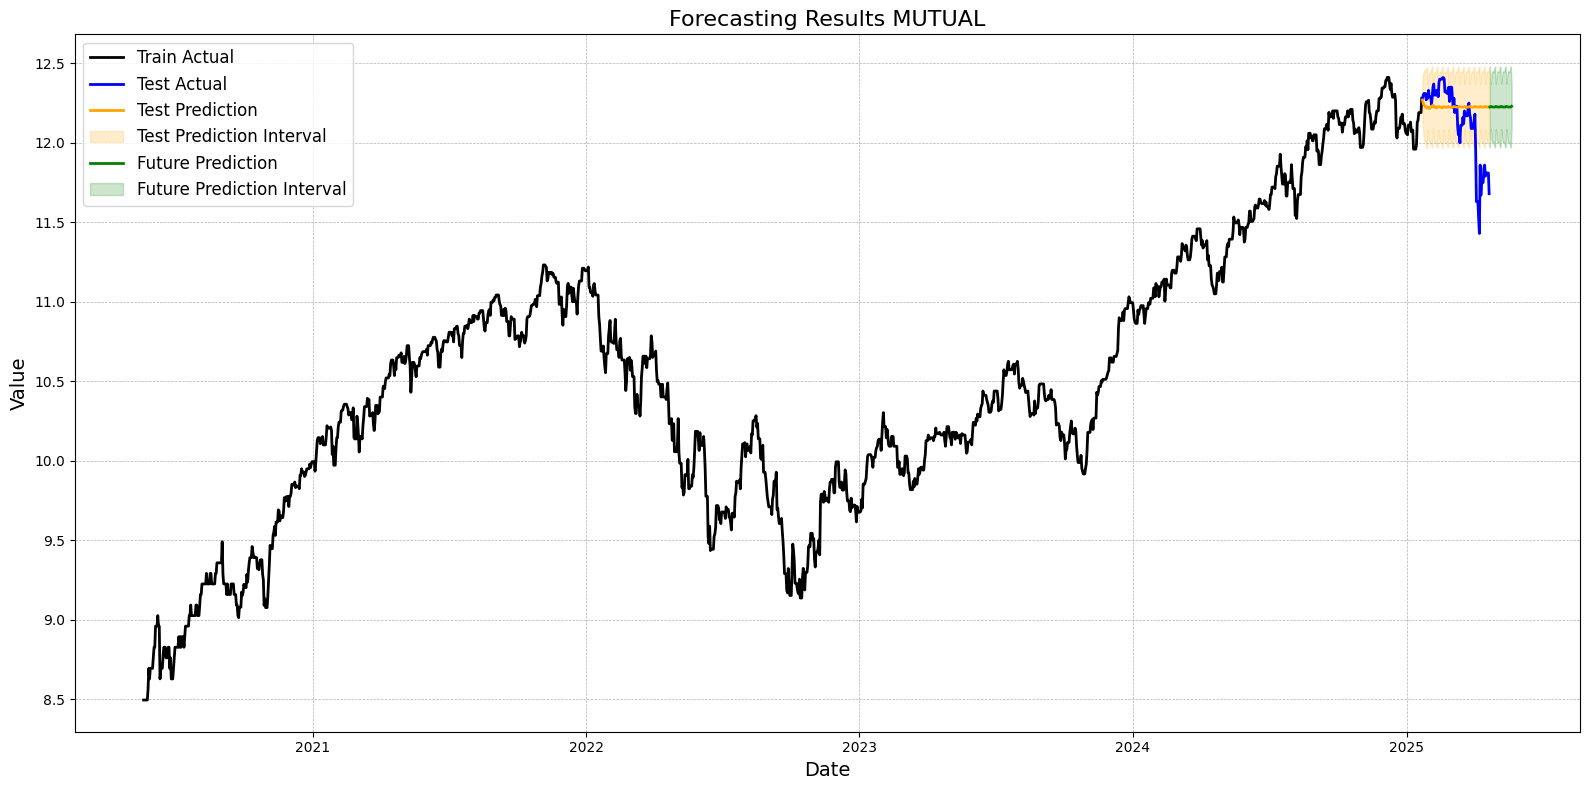

In [29]:
forecast_vis(train_result,test_result,prediction_result,"MUTUAL")

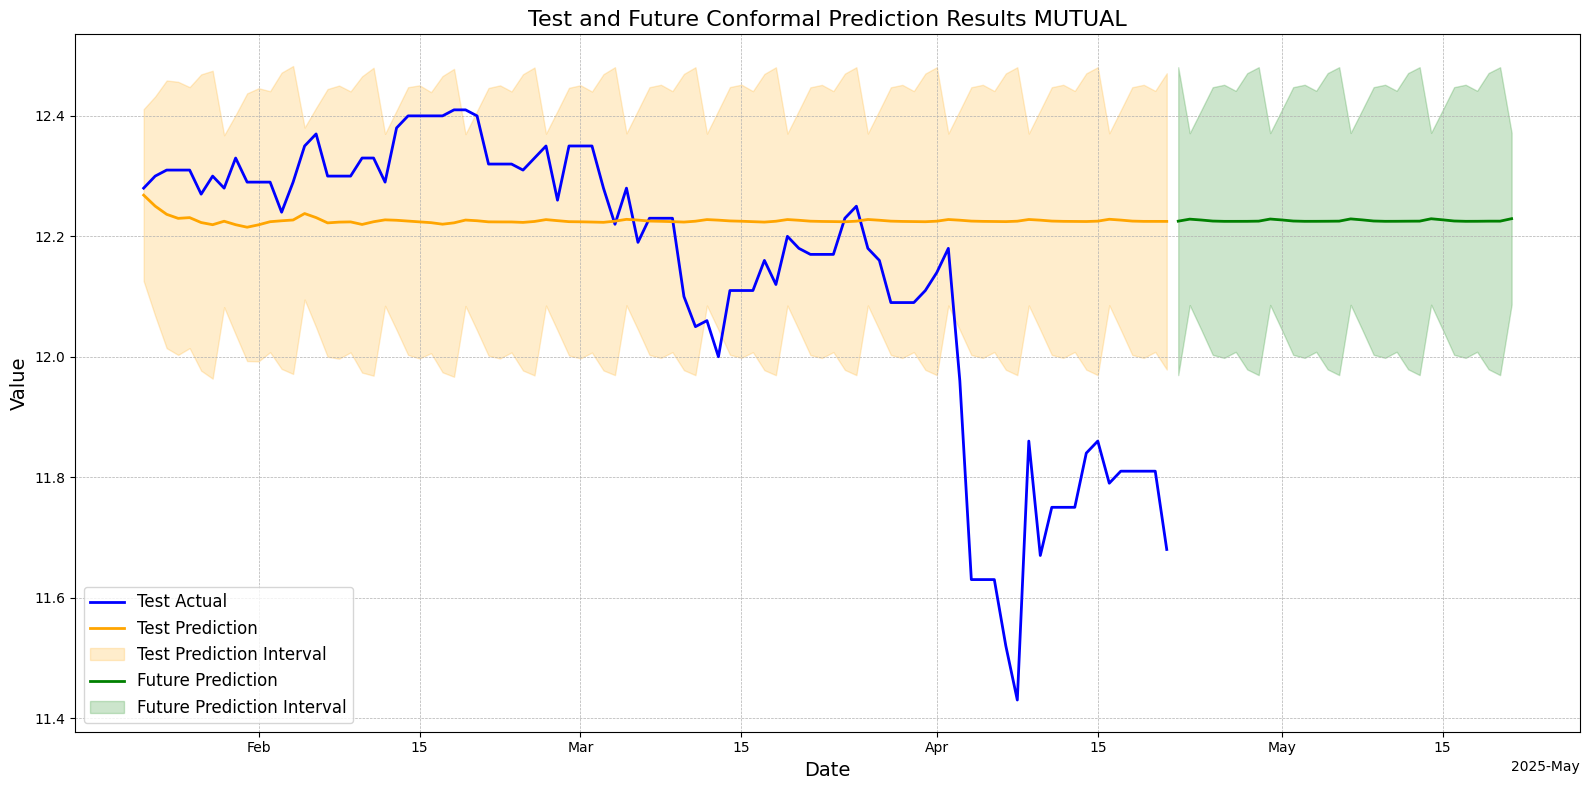

In [30]:
forecast_vis2(test_result, prediction_result,"MUTUAL")

### References

In [31]:
# https://docs.nixtla.io/docs/getting-started-timegpt_quickstart
# https://docs.nixtla.io/docs/tutorials-prediction_intervals
# https://docs.nixtla.io/docs/tutorials-fine_tuning